In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.optim as optim

from typing import *
from pathlib import Path

In [2]:
DATA_ROOT = Path("../data/brown")

In [3]:
N_EPOCHS = 1

# Building an LSTM from scratch

In this notebook, we'll be building our own LSTM and delving into why it performs so well across a wide range of tasks.

# The Basics of the LSTM

Before we actually build the LSTM, we'll need to understand its basic mechansim.

The below diagram shows the flow of information in an LSTM cell (image from Wikipedia)

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1920px-The_LSTM_cell.png)

The equation for the LSTM looks like this:

\begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
            c_t = f_t * c_{(t-1)} + i_t * g_t \\
            h_t = o_t * \tanh(c_t) \\
        \end{array}

It seems complex, but when you pick it apart, the LSTM is actually very simple. The core of the LSTM is the following equation:

\begin{array}{ll} \\
            c_t = f_t * c_{(t-1)} + i_t * g_t \\
\end{array}

Let's pick this equation apart: $ c_t $ is the new cell state, which is basically the memory of the LSTM. 

$ f_t $ is called the "forget gate": it dictates how much of the previous cell state to **retain** (but is slightly confusingly named the forget gate). 

$ i_t $ is the "input gate" and dictates how much to update the cell state with new information.

Finally, $ g_t $ is the information we use to update the cell state.

Basically, an LSTM chooses to keep a certain portion of its previous cell state and add a certain amount of new information. These proportions are controlled using gates.

Let's contrast this update rule with the update rule of a simpler RNN

$$ c_t = \tanh(W_hc_{t-1} + W_ix_t) $$

(To make the contrast clearer, I'm representing the hidden state of the RNN as $ c_t $.)

As you can see, there is a huge difference between the simple RNN's update rule and the LSTM's update rule. Whereas the RNN computes the new hidden state from scratch based on the previous hidden state and the input, the LSTM computes the new hidden state by choosing what to **add** to the current state. This is similar to how ResNets learn: they learn what to add to the current state/block instead of directly learning the new state. In other words, LSTMs are great primarily because they are **additive**. We'll formalize this intuition later when we examine the gradient flow, but this is the basic idea behind the LSTM.

Now that we have a basic understanding, let's start coding.

Side Note: One thing that is slightly confusing about the LSTM is that it has two "hidden states": $ c_t $ and $ h_t $. Intuitively, $ c_t $ is the "internal" hidden state that retains important information for longer timesteps, whereas $ h_t $ is the "external" hidden state that exposes that information to the outside world.


Side Note: If you're looking carefully, you'll notice that the bias terms are redundant. The reason they are there is for compatibility with the CuDNN backend. Until we touch on CuDNN, we'll use a single bias term.

# Implementing the LSTM

We'll be using PyTorch to write our own LSTM

In [4]:
from enum import IntEnum
class Dim(IntEnum):
    batch = 0
    seq = 1
    feature = 2

In [5]:
class NaiveLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        # input gate
        self.W_ii = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_hi = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = Parameter(torch.Tensor(hidden_sz))
        # forget gate
        self.W_if = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_hf = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = Parameter(torch.Tensor(hidden_sz))
        # ???
        self.W_ig = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_hg = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_g = Parameter(torch.Tensor(hidden_sz))
        # output gate
        self.W_io = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_ho = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x: torch.Tensor, 
                init_states: Optional[Tuple[torch.Tensor, torch.Tensor]]=None
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = torch.zeros(self.hidden_size).to(x.device), torch.zeros(self.hidden_size).to(x.device)
        else:
            h_t, c_t = init_states
        for t in range(seq_sz): # iterate over the time steps
            x_t = x[:, t, :]
            i_t = torch.sigmoid(x_t @ self.W_ii + h_t @ self.W_hi + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_if + h_t @ self.W_hf + self.b_f)
            g_t = torch.tanh(x_t @ self.W_ig + h_t @ self.W_hg + self.b_g)
            o_t = torch.sigmoid(x_t @ self.W_io + h_t @ self.W_ho + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(Dim.batch))
        hidden_seq = torch.cat(hidden_seq, dim=Dim.batch)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        return hidden_seq, (h_t, c_t)

Testing on some synthetic data

In [6]:
bs, seq_len, feat_sz, hidden_sz = 5, 10, 32, 16
arr = torch.randn(bs, seq_len, feat_sz)
lstm = NaiveLSTM(feat_sz, hidden_sz)

In [7]:
hs, (hn, cn) = lstm(arr)

In [8]:
hs.shape

torch.Size([5, 10, 16])

It looks like it works!

# Testing our implementation

Now, that we've covered the basics and have a minimally working LSTM, we'll put our model into action. Our testbed will be a character-level language modeling task. We'll be using the Brown Corpus which you can get via the commands below.

In [9]:
!mkdir -p {DATA_ROOT}

In [10]:
!curl http://www.sls.hawaii.edu/bley-vroman/brown.txt -o {DATA_ROOT / "brown.txt"}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: www.sls.hawaii.edu


We'll let AllenNLP handle the complexity of training the language model

In [11]:
from allennlp.data.dataset_readers import LanguageModelingReader
from allennlp.data.tokenizers import CharacterTokenizer
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data import Vocabulary
from allennlp.data.iterators import BasicIterator
from allennlp.training import Trainer
from sklearn.model_selection import train_test_split

char_tokenizer = CharacterTokenizer(lowercase_characters=True)

reader = LanguageModelingReader(
    tokens_per_instance=500,
    tokenizer=char_tokenizer,
    token_indexers = {"tokens": SingleIdTokenIndexer()},
)

train_ds = reader.read(DATA_ROOT / "brown.txt")
train_ds, val_ds = train_test_split(train_ds, random_state=0, test_size=0.1)

vocab = Vocabulary.from_instances(train_ds)

iterator = BasicIterator(batch_size=32)
iterator.index_with(vocab)

def train(model: nn.Module, epochs: int=10):
    trainer = Trainer(
        model=model.cuda() if torch.cuda.is_available() else model,
        optimizer=optim.Adam(model.parameters()),
        iterator=iterator, train_dataset=train_ds, 
        validation_dataset=val_ds, num_epochs=epochs,
        cuda_device=0 if torch.cuda.is_available() else -1
    )
    return trainer.train()

0it [00:00, ?it/s]02/15/2019 16:16:55 - INFO - allennlp.data.dataset_readers.language_modeling -   Creating dataset from all text in file: ../data/brown/brown.txt

 80%|███████▉  | 9561/11994 [00:00<00:00, 46578.75it/s]
11994it [00:12, 987.71it/s]4 [00:00<00:00, 45664.13it/s]
02/15/2019 16:16:58 - INFO - allennlp.data.vocabulary -   Fitting token dictionary from dataset.
100%|██████████| 10794/10794 [00:05<00:00, 1917.79it/s]


In [12]:
from allennlp.modules.seq2seq_encoders import PytorchSeq2SeqWrapper
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.models import Model
from allennlp.nn.util import get_text_field_mask

class LanguageModel(Model):
    def __init__(self, encoder: nn.RNN, vocab: Vocabulary,
                 embedding_dim: int=50):
        super().__init__(vocab=vocab)
        # char embedding
        self.vocab_size = vocab.get_vocab_size()
        self.padding_idx = vocab.get_token_index("@@PADDING@@")
        token_embedding = Embedding(
            num_embeddings=vocab.get_vocab_size(),
            embedding_dim=embedding_dim,
            padding_index=self.padding_idx,
        )
        self.embedding = BasicTextFieldEmbedder({"tokens": token_embedding})
        self.encoder = encoder
        self.projection = nn.Linear(self.encoder.hidden_size, self.vocab_size)
        self.loss = nn.CrossEntropyLoss(ignore_index=self.padding_idx)
    
    def forward(self, input_tokens: Dict[str, torch.Tensor],
                output_tokens: Dict[str, torch.Tensor]):
        # TODO: Implement
        embs = self.embedding(input_tokens)
        x, _ = self.encoder(embs)
        x = self.projection(x)
        if output_tokens is not None:
            loss = self.loss(x.view((-1, self.vocab_size)), output_tokens["tokens"].flatten())
        else:
            loss = None
        return {"loss": loss, "logits": x}

Now, let's try training

In [13]:
lm_naive = LanguageModel(NaiveLSTM(50, 125), vocab)
train(lm_naive, epochs=N_EPOCHS)

02/15/2019 16:17:04 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
02/15/2019 16:17:04 - INFO - allennlp.training.trainer -   Beginning training.
02/15/2019 16:17:04 - INFO - allennlp.training.trainer -   Epoch 0/0
02/15/2019 16:17:04 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 1729.343488
02/15/2019 16:17:04 - INFO - allennlp.training.trainer -   Training
loss: 2.6929 ||: 100%|██████████| 338/338 [17:04<00:00,  2.50s/it]
02/15/2019 16:34:09 - INFO - allennlp.training.trainer -   Validating
loss: 2.3200 ||: 100%|██████████| 38/38 [00:10<00:00,  4.15it/s]
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -                     Training |  Validation
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -   cpu_memory_MB |  1729.343  |       N/A
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -   loss          |     2.693  |     2.320
02/15/2019 16:34:19 - I

{'peak_cpu_memory_MB': 1729.343488,
 'training_duration': '00:17:14',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.692909450926019,
 'training_cpu_memory_MB': 1729.343488,
 'validation_loss': 2.3199655068548104,
 'best_epoch': 0,
 'best_validation_loss': 2.3199655068548104}

Now, let's compare with the official LSTM

In [14]:
lm_comparison = LanguageModel(nn.LSTM(50, 125, batch_first=True), vocab)
train(lm_comparison, epochs=N_EPOCHS)

02/15/2019 16:34:19 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -   Beginning training.
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -   Epoch 0/0
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 1828.790272
02/15/2019 16:34:19 - INFO - allennlp.training.trainer -   Training
loss: 2.6951 ||: 100%|██████████| 338/338 [03:34<00:00,  1.71it/s]
02/15/2019 16:37:53 - INFO - allennlp.training.trainer -   Validating
loss: 2.3065 ||: 100%|██████████| 38/38 [00:07<00:00,  6.44it/s]
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -                     Training |  Validation
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -   cpu_memory_MB |  1828.790  |       N/A
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -   loss          |     2.695  |     2.307
02/15/2019 16:38:01 - I

{'peak_cpu_memory_MB': 1828.790272,
 'training_duration': '00:03:41',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.695129863609224,
 'training_cpu_memory_MB': 1828.790272,
 'validation_loss': 2.30654828171981,
 'best_epoch': 0,
 'best_validation_loss': 2.30654828171981}

Out model is a lot slower, but we're getting similar performance, so it looks good! We'll look at how we can optimize the performance later.

Now, let's compare the performance of the LSTM with a much simpler RNN

In [15]:
class SimpleRNN(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_sz, self.hidden_size = input_sz, hidden_sz
        self.weight_ih = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.weight_hh = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.bias_hh = Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weight_ih)
        nn.init.xavier_uniform_(self.weight_hh)
        nn.init.zeros_(self.bias_hh)
    
    def forward(self, x: torch.Tensor, init_state=None) -> torch.Tensor:
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_state is None:
            h_t = torch.zeros(self.hidden_size).to(x.device)
        else:
            h_t = init_state

        for t in range(seq_sz):
            x_t = x[:, t, :]
            h_t = torch.tanh(x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias_hh)
            hidden_seq.append(h_t.unsqueeze(Dim.batch))
        hidden_seq = torch.cat(hidden_seq, dim=Dim.batch)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        return hidden_seq, h_t

In [16]:
lm_simplernn = LanguageModel(SimpleRNN(50, 125), vocab)
train(lm_simplernn, epochs=N_EPOCHS)

02/15/2019 16:38:01 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -   Beginning training.
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -   Epoch 0/0
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 1905.47968
02/15/2019 16:38:01 - INFO - allennlp.training.trainer -   Training
loss: 2.5764 ||: 100%|██████████| 338/338 [13:24<00:00,  1.95s/it]
02/15/2019 16:51:26 - INFO - allennlp.training.trainer -   Validating
loss: 2.2059 ||: 100%|██████████| 38/38 [00:03<00:00, 13.33it/s]
02/15/2019 16:51:29 - INFO - allennlp.training.trainer -                     Training |  Validation
02/15/2019 16:51:29 - INFO - allennlp.training.trainer -   cpu_memory_MB |  1905.480  |       N/A
02/15/2019 16:51:29 - INFO - allennlp.training.trainer -   loss          |     2.576  |     2.206
02/15/2019 16:51:29 - IN

{'peak_cpu_memory_MB': 1905.47968,
 'training_duration': '00:13:27',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.576429249266901,
 'training_cpu_memory_MB': 1905.47968,
 'validation_loss': 2.205946420368395,
 'best_epoch': 0,
 'best_validation_loss': 2.205946420368395}

# Understanding the dynamics of LSTM learning

Why exactly do LSTMs learn so well? Let's analyze the dynamics of LSTM learning by checking how the gradients change and comparing them to the gradients of a simple RNN.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
test_batch = next(iterator(train_ds))
test_embeddings = lm_naive.embedding(test_batch["input_tokens"])

### The gradient dynamics of simple RNNs

First, let's check how the gradients of a simple RNN change with regards to the initial inputs

In [19]:
rnn = SimpleRNN(50, 125)

In [20]:
def rnn_step(x_t, h_t, weight_ih, weight_hh, bias_hh):
    return torch.tanh(x_t @ weight_ih + h_t @ weight_hh + bias_hh)

In [21]:
h_0 = torch.zeros(rnn.hidden_size, requires_grad=True).to(test_embeddings.device)
h_t = h_0
grads = []

for t in range(100):
    h_t = rnn_step(
        test_embeddings[:, t, :], h_t,
        rnn.weight_ih, rnn.weight_hh, rnn.bias_hh,
    )
    loss = h_t.abs().sum() # we'll use the l1 norm of the current hidden state as the loss
    loss.backward(retain_graph=True)
    grads.append(torch.norm(h_0.grad).item())
    h_0.grad.zero_()

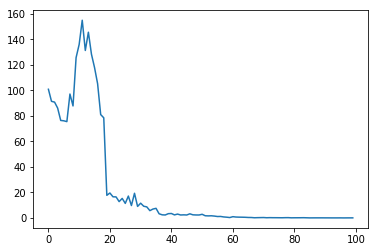

In [22]:
plt.plot(grads)

As you can see, the gradients decay as time progresses. This is one of the factors that makes simple RNNs more difficult to train compared to LSTMs. 

### The gradient dynamics of LSTMs

Next, let's compare the same plot with LSTMs. Though this might not be very well known, the original formulation of the LSTM did not have a forget gate; we'll be using the formulation without the forget gate first and then see how the forget gate changes the dynamics.

In [23]:
lstm = NaiveLSTM(50, 125)
hidden_size = lstm.hidden_size

In [24]:
def lstm_step(x_t, h_t, c_t, W_ii, W_hi, b_i, W_if, W_hf, b_f,
              W_ig, W_hg, b_g, W_io, W_ho, b_o, use_forget_gate=False):
    i_t = torch.sigmoid(x_t @ W_ii + h_t @ W_hi + lstm.b_i)
    if use_forget_gate:
        f_t = torch.sigmoid(x_t @ W_if + h_t @ W_hf + lstm.b_f)
    g_t = torch.tanh(x_t @ W_ig + h_t @ W_hg + lstm.b_g)
    o_t = torch.sigmoid(x_t @ W_io + h_t @ W_ho + lstm.b_o)
    if use_forget_gate:
        c_t = f_t * c_t + i_t * g_t
    else:
        c_t = c_t + i_t * g_t
    h_t = o_t * torch.tanh(c_t)
    return h_t, c_t

In [25]:
# generate 
h_0, c_0 = (torch.zeros(hidden_size, requires_grad=True), 
            torch.zeros(hidden_size, requires_grad=True))
grads = []
h_t, c_t = h_0, c_0
for t in range(100):
    h_t, c_t = lstm_step(
        test_embeddings[:, t, :], h_t, c_t,
        lstm.W_ii, lstm.W_hi, lstm.b_i,
        lstm.W_if, lstm.W_hf, lstm.b_f,
        lstm.W_ig, lstm.W_hg, lstm.b_g,
        lstm.W_io, lstm.W_ho, lstm.b_o,
        use_forget_gate=False,
    )
    loss = h_t.abs().sum()
    loss.backward(retain_graph=True)
    grads.append(torch.norm(h_0.grad).item())
    h_0.grad.zero_()
    lstm.zero_grad()

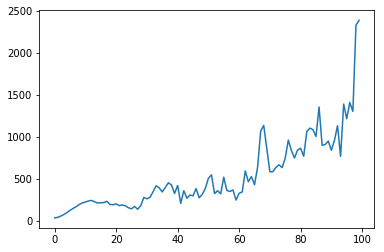

In [26]:
plt.plot(grads)

Notice how the gradient keeps on accumulating. The reason the gradient behaves this way is because of the update rule
$$ c_t = c_{t-1} + i_t * g_t $$

If you're familiar with gradient calculus, you'll see that the gradients for $ c_t $ propagate straight back to the gradients for $ c_{t-1} $. Therefore, the gradient of the initial timestep keeps increasing: since $ c_0 $ influences $ c_1 $, which in turn influences $ c_2 $, and so on, the influence of the initial state never disappears.

Of course, this can be a mixed blessing: sometimes we don't want the current timestep to influence the hidden state 200 steps into the future. Sometimes, we want to "forget" the information we learned earlier and overwrite it with what we have newly learned. This is where the forget gate comes into play.

### Turning the forget gate on

The forget gate was originally proposed in the paper [Learning to Forget: Continual Prediction with LSTM](https://www.semanticscholar.org/paper/Learning-to-Forget%3A-Continual-Prediction-with-LSTM-Gers-Schmidhuber/11540131eae85b2e11d53df7f1360eeb6476e7f4). Let's see how the gradients change when we turn the forget gate on. Adhering to best practices, we'll initialize the bias for the forget gate to 1.

In [27]:
lstm.b_f.data = torch.ones_like(lstm.b_f.data)

In [28]:
# generate 
h_0, c_0 = (torch.zeros(hidden_size, requires_grad=True), 
            torch.zeros(hidden_size, requires_grad=True))
grads = []
h_t, c_t = h_0, c_0
for t in range(100):
    h_t, c_t = lstm_step(
        test_embeddings[:, t, :], h_t, c_t,
        lstm.W_ii, lstm.W_hi, lstm.b_i,
        lstm.W_if, lstm.W_hf, lstm.b_f,
        lstm.W_ig, lstm.W_hg, lstm.b_g,
        lstm.W_io, lstm.W_ho, lstm.b_o,
        use_forget_gate=True,
    )
    loss = h_t.abs().sum()
    loss.backward(retain_graph=True)
    grads.append(torch.norm(h_0.grad).item())
    h_0.grad.zero_()

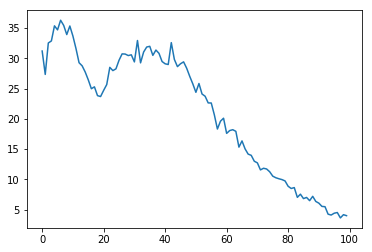

In [29]:
plt.plot(grads)

Notice how the gradients decay much more slowly than in the case of the Simple RNN. On the other hand, when we don't initialize the forget gate bias to 1... 

In [30]:
lstm.b_f.data = torch.zeros_like(lstm.b_f.data)

In [31]:
h_0, c_0 = (torch.zeros(hidden_size, requires_grad=True), 
            torch.zeros(hidden_size, requires_grad=True))
grads = []
h_t, c_t = h_0, c_0
for t in range(100):
    h_t, c_t = lstm_step(
        test_embeddings[:, t, :], h_t, c_t,
        lstm.W_ii, lstm.W_hi, lstm.b_i,
        lstm.W_if, lstm.W_hf, lstm.b_f,
        lstm.W_ig, lstm.W_hg, lstm.b_g,
        lstm.W_io, lstm.W_ho, lstm.b_o,
        use_forget_gate=True,
    )
    loss = h_t.abs().sum()
    loss.backward(retain_graph=True)
    grads.append(torch.norm(h_0.grad).item())
    h_0.grad.zero_()

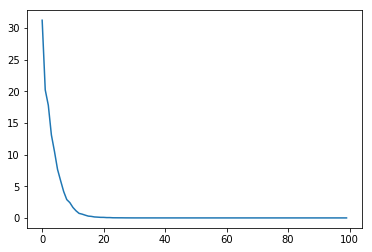

In [32]:
plt.plot(grads)

The gradient decays much more quickly now: this is why initializing the forget gate to 1 is a good idea, at least in the initial stages of training. 

Now, let's see what happens when we initalize the forget gate to -1.

In [33]:
lstm.b_f.data = -torch.ones_like(lstm.b_f.data)

In [34]:
# generate 
h_0, c_0 = (torch.zeros(hidden_size, requires_grad=True), 
            torch.zeros(hidden_size, requires_grad=True))
grads = []
h_t, c_t = h_0, c_0
for t in range(100):
    h_t, c_t = lstm_step(
        test_embeddings[:, t, :], h_t, c_t,
        lstm.W_ii, lstm.W_hi, lstm.b_i,
        lstm.W_if, lstm.W_hf, lstm.b_f,
        lstm.W_ig, lstm.W_hg, lstm.b_g,
        lstm.W_io, lstm.W_ho, lstm.b_o,
        use_forget_gate=True,
    )
    loss = h_t.abs().sum()
    loss.backward(retain_graph=True)
    grads.append(torch.norm(h_0.grad).item())
    h_0.grad.zero_()

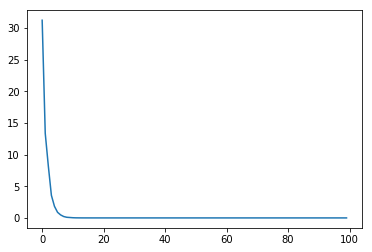

In [35]:
plt.plot(grads)

The weights decay even faster now.

We looked at a lot of charts, but the most important point is that the LSTM basically has control over how much of the gradient to allow to flow through each timestep. This is what makes them so easy to train.

# Making our LSTM Faster

Remember how slow our implementation of the LSTM was slow? Let's see how we can speed it up.

If you look at the code for our LSTM carefully, you'll notice that there is a lot of shared processing that could be batched together. For instance, the input and forget gates are both computed based on a linear transformation of the input and the hidden states.


We can group these computations into just two matrix multiplications. The code now looks like this:

In [36]:
class OptimizedLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.weight_ih = Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.weight_hh = Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x: torch.Tensor, 
                init_states: Optional[Tuple[torch.Tensor]]=None
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(self.hidden_size).to(x.device), 
                        torch.zeros(self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(Dim.batch))
        hidden_seq = torch.cat(hidden_seq, dim=Dim.batch)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        return hidden_seq, (h_t, c_t)

In [37]:
lstm = OptimizedLSTM(100, 32)

In [38]:
a = torch.arange(5 * 10 * 100).view((5, 10, 100))

In [39]:
hs, _ = lstm(a.float())

In [40]:
hs.shape

torch.Size([5, 10, 32])

Now, let's see how the training speed changes

In [41]:
lm_optimized = LanguageModel(OptimizedLSTM(50, 125), vocab)
train(lm_optimized, epochs=N_EPOCHS)

02/15/2019 16:53:36 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
02/15/2019 16:53:36 - INFO - allennlp.training.trainer -   Beginning training.
02/15/2019 16:53:36 - INFO - allennlp.training.trainer -   Epoch 0/0
02/15/2019 16:53:36 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 1905.47968
02/15/2019 16:53:36 - INFO - allennlp.training.trainer -   Training
loss: 2.7769 ||: 100%|██████████| 338/338 [13:52<00:00,  2.02s/it]
02/15/2019 17:07:28 - INFO - allennlp.training.trainer -   Validating
loss: 2.4106 ||: 100%|██████████| 38/38 [00:06<00:00,  6.66it/s]
02/15/2019 17:07:35 - INFO - allennlp.training.trainer -                     Training |  Validation
02/15/2019 17:07:35 - INFO - allennlp.training.trainer -   cpu_memory_MB |  1905.480  |       N/A
02/15/2019 17:07:35 - INFO - allennlp.training.trainer -   loss          |     2.777  |     2.411
02/15/2019 17:07:35 - IN

{'peak_cpu_memory_MB': 1905.47968,
 'training_duration': '00:13:58',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.7768504443253286,
 'training_cpu_memory_MB': 1905.47968,
 'validation_loss': 2.4106190016395166,
 'best_epoch': 0,
 'best_validation_loss': 2.4106190016395166}

The model is faster now, but still not quite as fast as we might want it to be. To really make our LSTM fast, we'll need to pass it over to CuDNN. But that's a topic for another post/notebook.